Imports etc.


In [1]:
import sys
sys.path.insert(1, '/home/yannik/vssil')

import matplotlib.pyplot as plt
import pylab
import torch
from torchvision.io import read_video

from src.utils.kpt_utils import get_image_patches, kpts_2_img_coordinates
from contrastive_loss_test_data.test_data import load_sample_images
from contrastive_loss_test_data.test_keypoints import get_perfect_keypoints, get_bad_keypoints, get_random_keypoints

Get test data

In [2]:
torch.manual_seed(123)

sample_size = 4
batch_size = 16

img_tensor = load_sample_images(sample_size=sample_size,
                                path="/home/yannik/vssil/contrastive_loss_test_data/990000.mp4").unsqueeze(0)
img_tensor = img_tensor.repeat((batch_size, 1, 1, 1, 1))
N, T, C, H, W = img_tensor.shape

time_window = 5
patch_size = (35, 35)

pos_range = max(int(time_window / 2), 1) if time_window > 1 else 0
center_index = int(patch_size[0] / 2)

step_matrix = torch.ones(patch_size + (2,))

step_w = 2 / W
step_h = 2 / H

for k in range(0, patch_size[0]):
    for l in range(0, patch_size[1]):
        step_matrix[k, l, 0] = (l - center_index) * step_w
        step_matrix[k, l, 1] = (k - center_index) * step_h

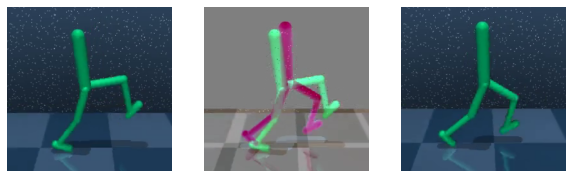

In [3]:
fig, ax = plt.subplots(1, 3, figsize=(10, 5))
ax[0].imshow(img_tensor[0, 0].permute(1, 2, 0))
ax[0].axis('off')
ax[1].imshow((img_tensor[0, 0] - img_tensor[0, -1] + 0.5).clip(0.0, 1.0).permute(1, 2, 0))
ax[1].axis('off')
ax[2].imshow(img_tensor[0, -1].permute(1, 2, 0))
ax[2].axis('off')
plt.show()

Perfect key-points

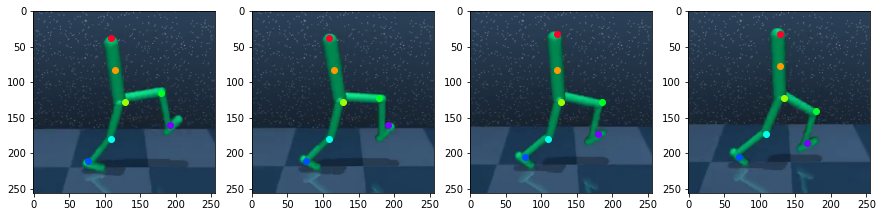

In [11]:
perfect_kpt_coordinates = get_perfect_keypoints(T=sample_size).unsqueeze(0)
perfect_kpt_coordinates = perfect_kpt_coordinates.repeat((batch_size, 1, 1, 1))
_, _, K, D = perfect_kpt_coordinates.shape

cm = pylab.get_cmap('gist_rainbow')
perfect_kpts = kpts_2_img_coordinates(perfect_kpt_coordinates, tuple(img_tensor.shape[-2:]))
fig, ax = plt.subplots(1, sample_size, figsize=(15, 5))
for t in range(sample_size):
    ax[t].imshow(img_tensor[0, t].permute(1, 2, 0))
    for k in range(K):
        ax[t].scatter(perfect_kpts[0, t, k, 0], perfect_kpts[0, t, k, 1], color=cm(1.*k/K))
plt.show()

torch.Size([16, 4, 3, 256, 256])
torch.Size([16, 4, 7, 3])
torch.Size([16, 4, 7, 3, 32, 32])


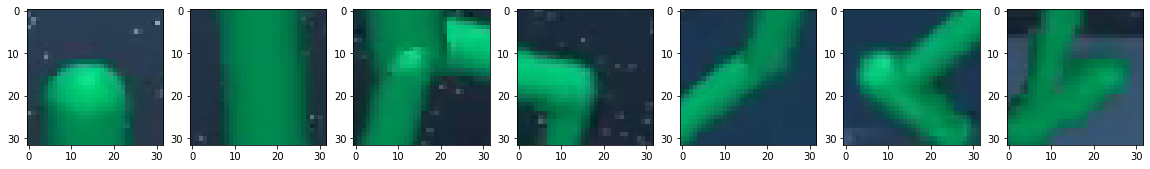

In [12]:
print(img_tensor.shape)  # (N, T, C, H, W)
print(perfect_kpt_coordinates.shape)  # (N, T, K, D)

perfect_kpt_patches = get_image_patches(image_sequence=img_tensor[0:1, ...],
                                        kpt_sequence=perfect_kpt_coordinates[0:1, ...],
                                        patch_size=(32, 32)).repeat((N, 1, 1, 1, 1, 1))

print(perfect_kpt_patches.shape)  # (N, T, K, C, H', W')

fig, ax = plt.subplots(1, K, figsize=(20, 10))
for k in range(K):
    ax[k].imshow(perfect_kpt_patches[0, 2, k, ...].permute(1, 2, 0).cpu().numpy())

Worse key-points

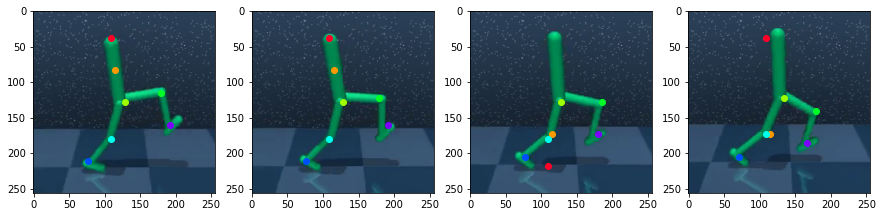

In [13]:
bad_kpt_coordinates = get_bad_keypoints(T=sample_size).unsqueeze(0)
bad_kpt_coordinates = bad_kpt_coordinates.repeat((batch_size, 1, 1, 1))
_, _, K, D = bad_kpt_coordinates.shape

cm = pylab.get_cmap('gist_rainbow')
bad_kpts = kpts_2_img_coordinates(bad_kpt_coordinates, tuple(img_tensor.shape[-2:]))
fig, ax = plt.subplots(1, sample_size, figsize=(15, 5))
for t in range(sample_size):
    ax[t].imshow(img_tensor[0, t].permute(1, 2, 0))
    for k in range(K):
        ax[t].scatter(bad_kpts[0, t, k, 0], bad_kpts[0, t, k, 1], color=cm(1.*k/K))
plt.show()

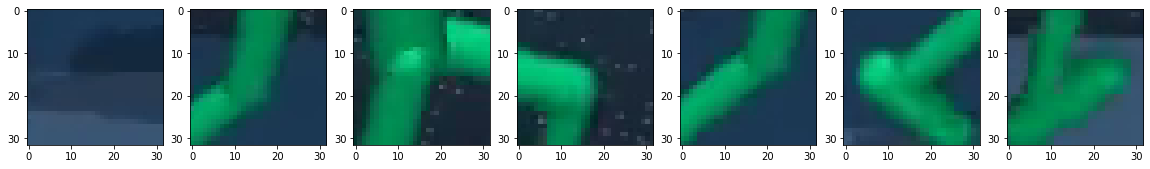

In [7]:
bad_kpt_patches = get_image_patches(image_sequence=img_tensor[0:1, ...],
                                        kpt_sequence=bad_kpt_coordinates[0:1, ...],
                                        patch_size=(32, 32)).repeat((N, 1, 1, 1, 1, 1))

fig, ax = plt.subplots(1, K, figsize=(20, 10))
for k in range(K):
    ax[k].imshow(bad_kpt_patches[0, 2, k, ...].permute(1, 2, 0).cpu().numpy())

Random key-points

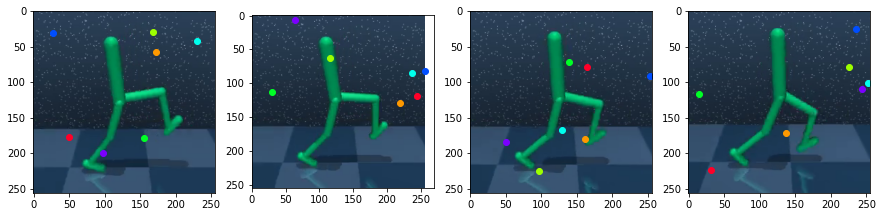

In [14]:
random_kpt_coordinates = get_random_keypoints(T=sample_size).unsqueeze(0)
random_kpt_coordinates = random_kpt_coordinates.repeat((batch_size, 1, 1, 1))
_, _, K, D = random_kpt_coordinates.shape

cm = pylab.get_cmap('gist_rainbow')
random_kpts = kpts_2_img_coordinates(random_kpt_coordinates, tuple(img_tensor.shape[-2:]))
fig, ax = plt.subplots(1, sample_size, figsize=(15, 5))
for t in range(sample_size):
    ax[t].imshow(img_tensor[0, t].permute(1, 2, 0))
    for k in range(K):
        ax[t].scatter(random_kpts[0, t, k, 0], random_kpts[0, t, k, 1], color=cm(1.*k/K))
plt.show()

torch.Size([16, 4, 7, 3])


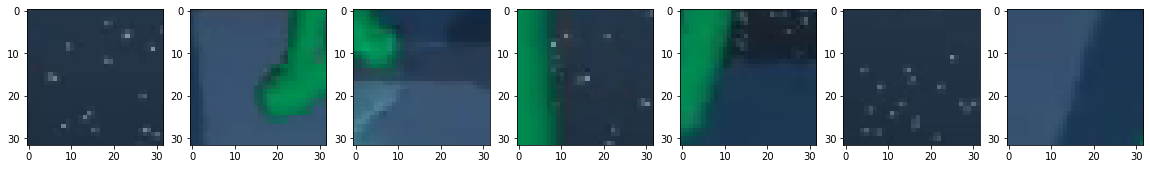

In [15]:
print(random_kpt_coordinates.shape)
random_kpt_patches = get_image_patches(image_sequence=img_tensor[0:1, ...],
                                        kpt_sequence=random_kpt_coordinates[0:1, ...],
                                        patch_size=(32, 32)).repeat((N, 1, 1, 1, 1, 1))

fig, ax = plt.subplots(1, K, figsize=(20, 10))
for k in range(K):
    ax[k].imshow(random_kpt_patches[0, 2, k, ...].permute(1, 2, 0).cpu().numpy())

Evaluate image patches

In [10]:
from src.losses.spatial_consistency_loss import spatial_consistency_loss
from src.losses.kpt_metrics import ft_tracking_metric, grad_tracking_metric, distribution_metric,\
    visual_difference_metric, visual_similarity_metric

ImportError: cannot import name 'distribution_metric' from 'src.losses.kpt_metrics' (/home/yannik/vssil/src/losses/kpt_metrics.py)

In [ ]:
# Spatial consistency
# The perfect key-points should have the smoothest movement -> lowest loss
M_smooth_perfect = spatial_consistency_loss(perfect_kpt_coordinates)
M_smooth_bad = spatial_consistency_loss(bad_kpt_coordinates)
M_smooth_random = spatial_consistency_loss(random_kpt_coordinates)

print("Perfect key-points: ", M_smooth_perfect)
print("Bad key-points: ", M_smooth_bad)
print("Random key-points: ", M_smooth_random)

In [ ]:
# Distribution of key-point across image
# Perfect key-points should have as few overlapping patches as possible
# -> Their distances should be as high as possible? Random key-points will have very high distances

M_distr_perfect = distribution_metric(perfect_kpt_coordinates, (32, 32))
M_distr_bad = distribution_metric(bad_kpt_coordinates, (32, 32))
M_distr_random = distribution_metric(random_kpt_coordinates, (32, 32))

print("Perfect key-points: ", M_distr_perfect)
print("Bad key-points: ", M_distr_bad)
print("Random key-points: ", M_distr_random)

In [ ]:
# Tracking objects over time
# Perfect key-points should have minimal changes in their tracked object over time
M_track_perfect = grad_tracking_metric(perfect_kpt_patches)
M_track_bad = grad_tracking_metric(bad_kpt_patches)
M_track_random = grad_tracking_metric(random_kpt_patches)

print("Perfect key-points: ", M_track_perfect)
print("Bad key-points: ", M_track_bad)
print("Random key-points: ", M_track_random)

In [ ]:
# Tracking visually different objects
# Perfect key-points should have max distance between feature encodings of their patches across key-points
M_vis_perfect = visual_difference_metric(perfect_kpt_patches)
M_vis_bad = visual_difference_metric(bad_kpt_patches)
M_vis_random = visual_difference_metric(random_kpt_patches)

print("Perfect key-points: ", M_vis_perfect)
print("Bad key-points: ", M_vis_bad)
print("Random key-points: ", M_vis_random)

In [ ]:
# Tracking visually similar objects over time
# The patches around perfect key-points should have small distances over time in a MKD feature space 
M_vis_perfect = visual_similarity_metric(perfect_kpt_patches)
M_vis_bad = visual_similarity_metric(bad_kpt_patches)
M_vis_random = visual_similarity_metric(random_kpt_patches)

print("Perfect key-points: ", M_vis_perfect)
print("Bad key-points: ", M_vis_bad)
print("Random key-points: ", M_vis_random)